In [1]:
# A script to impute missing values for for stand age in forest inventory plots
# Read in plot-level summary data of PNW FIA Database
# These plot-level summaries were exported as a .csv from the Access Database

In [2]:
# load our libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error
from math import sqrt

In [3]:
# read in the PNW FIA Database, with plot("condition")-level summary data
PNW_FIADB = pd.read_csv("G:/projects/ForestPlanner_2015/Data/Work/IDB_SUMMARY_2015-10-23.csv")
PNW_FIADB.head()

,PLOT_ID,COND_ID,LATITUDE_FUZZ,LONGITUDE_FUZZ,Calc_SLOPE,Calc_ASPECT,ELEV_FT,STAND_SIZE_CLASS,QMD_TOT_CM,SITE_CLASS_FIA,AGE_Calc,FIA_FOREST_TYPE_NAME,FOR_TYPE,FOR_TYPE_SECDRY,MAI,SumOfBA_FT2_AC,SumOfBIOM_TR_ABV_GRND_TON,SumOfVOL_AC_GRS_FT3,GLC_GROUP
0,3,105,44.70,-123.32,0,0,394,3,91.70,3,65,Douglas-fir,202,NaN,129.59,23.64,4.69,761.00,F
1,3,108,44.70,-123.32,0,0,394,2,10.81,3,15,Oregon white oak,815,NaN,129.59,14.37,0.07,107.55,F
2,4,133,44.64,-123.43,0,0,600,3,23.05,NaN,35,Scotch pine,130,NaN,NaN,112.93,0.99,2495.75,F
3,5,148,44.69,-123.43,30,360,600,3,38.78,2,45,Douglas-fir,202,NaN,191.88,152.49,26.76,5614.54,F
4,6,174,44.71,-123.50,30,315,1201,3,35.51,2,35,Douglas-fir,202,NaN,201.86,122.00,3.15,4521.56,F


In [4]:
# rename a few columns
PNW_FIADB.rename(columns={'AGE_Calc': 'COND_AGE', 'LATITUDE_FUZZ': 'LAT', 'LONGITUDE_FUZZ': 'LON', 
                          'Calc_SLOPE': 'SLOPE', 'Calc_ASPECT': 'ASPECT', 'ELEV_FT': 'ELEV'}, inplace=True)


In [5]:
# set thte COND_CN field as the dataframe index
PNW_FIADB.set_index("COND_ID", inplace = True)

In [6]:
PNW_FIADB.describe()

,PLOT_ID,LAT,LON,SLOPE,ASPECT,ELEV,STAND_SIZE_CLASS,QMD_TOT_CM,SITE_CLASS_FIA,COND_AGE,FOR_TYPE,FOR_TYPE_SECDRY,MAI,SumOfBA_FT2_AC,SumOfBIOM_TR_ABV_GRND_TON,SumOfVOL_AC_GRS_FT3
count,24259.000000,24259.000000,24259.000000,24255.000000,24255.000000,24205.000000,24243.000000,23884.000000,23979.000000,22986.000000,24259.000000,2613.000000,18139.000000,23752.000000,24207.000000,24249.000000
mean,14674.469599,43.690303,-121.033802,30.780952,196.104473,3811.497253,3.257848,32.738325,4.546436,106.981641,220.183478,389.652507,95.813147,125.565238,44.594977,3480.787005
std,8593.758660,3.437008,1.972498,23.255176,110.734799,1970.490619,1.275918,17.190702,1.605430,79.706468,193.797361,235.204377,59.413856,92.316470,72.856389,3728.646719
min,3.000000,32.740000,-124.710000,0.000000,0.000000,3.000000,0.000000,0.100000,1.000000,0.000000,11.000000,11.000000,-10.370000,0.040000,0.000000,0.000000
25%,6916.500000,41.685000,-122.530000,10.000000,90.000000,2362.000000,3.000000,21.270000,3.000000,45.000000,108.000000,202.000000,49.175000,53.665000,4.730000,828.760000
50%,14024.000000,44.150000,-121.380000,28.000000,180.000000,4000.000000,3.000000,31.650000,5.000000,95.000000,202.000000,351.000000,81.610000,106.940000,17.070000,2243.240000
75%,22076.000000,46.140000,-119.430000,47.000000,270.000000,5180.000000,4.000000,42.730000,6.000000,155.000000,263.000000,431.000000,132.820000,179.980000,50.070000,4884.390000
max,30942.000000,49.000000,-116.350000,999.000000,999.000000,11299.000000,7.000000,279.800000,7.000000,300.000000,999.000000,999.000000,556.510000,1124.690000,1631.090000,68646.200000


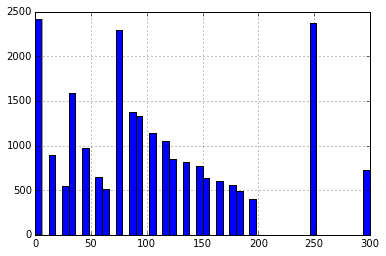

In [7]:
# take a look at the histogram of ages
PNW_FIADB.COND_AGE.hist(bins=50)

In [8]:
# some of our columns need to be formatted as factors/categorical variables
# FORTYPCD (Forest Type), SITECLCD (Site Class), SOIL_ROOTING_DEPTH_PNW, 
# STND_COND_CD_PNWRS (Stand condition code, e.g., grass-forb, open sawtimber, closed sapling-pole-sawtimber, old-growth)
# STND_STRUC_CD_PNWRS (Stand Structure, e.g., even-aged single story, two-story, uneven-aged, mosaic), 
# PHYSCLCD (Soil-Climate Type)
cat_cols = ["STAND_SIZE_CLASS", "SITE_CLASS_FIA", "FOR_TYPE", "FOR_TYPE_SECDRY"]
for col in cat_cols:
    if col in ["FOR_TYPE", "FOR_TYPE_SECDRY"]:
        PNW_FIADB[col] = PNW_FIADB[col].astype('category')
    else:
        PNW_FIADB[col] = PNW_FIADB[col].astype('category').cat.as_ordered()

In [9]:
# How many missing values do we have
print("Out of " + str(len(PNW_FIADB)) + " plots:")

# create a list of fields (other than age) with nulls
hasNaNs = []

for col in PNW_FIADB.columns.values:
    print(col + ": " + str(PNW_FIADB[col].isnull().sum()) + " nulls")
    if col != "COND_AGE" and PNW_FIADB[col].isnull().sum() >0:
        hasNaNs.append(col)
print(hasNaNs)

Out of 24259 plots:
PLOT_ID: 0 nulls
LAT: 0 nulls
LON: 0 nulls
SLOPE: 4 nulls
ASPECT: 4 nulls
ELEV: 54 nulls
STAND_SIZE_CLASS: 16 nulls
QMD_TOT_CM: 375 nulls
SITE_CLASS_FIA: 280 nulls
COND_AGE: 1273 nulls
FIA_FOREST_TYPE_NAME: 0 nulls
FOR_TYPE: 0 nulls
FOR_TYPE_SECDRY: 21646 nulls
MAI: 6120 nulls
SumOfBA_FT2_AC: 507 nulls
SumOfBIOM_TR_ABV_GRND_TON: 52 nulls
SumOfVOL_AC_GRS_FT3: 10 nulls
GLC_GROUP: 0 nulls
['SLOPE', 'ASPECT', 'ELEV', 'STAND_SIZE_CLASS', 'QMD_TOT_CM', 'SITE_CLASS_FIA', 'FOR_TYPE_SECDRY', 'MAI', 'SumOfBA_FT2_AC', 'SumOfBIOM_TR_ABV_GRND_TON', 'SumOfVOL_AC_GRS_FT3']


In [10]:
# See how many plots with missing ages also have missing nulls in other columns
for col in hasNaNs:
    print(col, str(PNW_FIADB.COND_AGE.loc[PNW_FIADB[col].isnull()].isnull().sum()))

('SLOPE', '1')
('ASPECT', '1')
('ELEV', '9')
('STAND_SIZE_CLASS', '16')
('QMD_TOT_CM', '54')
('SITE_CLASS_FIA', '115')
('FOR_TYPE_SECDRY', '1237')
('MAI', '1174')
('SumOfBA_FT2_AC', '25')
('SumOfBIOM_TR_ABV_GRND_TON', '16')
('SumOfVOL_AC_GRS_FT3', '4')


In [11]:
# columns of important predictor variables
dropNaNcols = ["STAND_SIZE_CLASS", "QMD_TOT_CM", "SumOfBA_FT2_AC", "SumOfBIOM_TR_ABV_GRND_TON", "SumOfVOL_AC_GRS_FT3", "SLOPE", "ELEV"]

In [12]:
# We could try to fill in missing values for some predictor variables, or just ignore them
# Let's see whether random forest thinks these values are helpful when we train the model 
# on a dataset that drops the plots where values are not missing
# and also drops the columns that aren't predictors (PLT_CN, FORTYPE)
noNaNs = PNW_FIADB.dropna(axis=0, how='any', thresh=None, subset=dropNaNcols, inplace=False)

In [13]:
# Number of plots with complete predictor variables
print(str(len(noNaNs))+ " plots with complete predictor variables")

23521 plots with complete predictor variables


In [14]:
# Create a random forest training set of data from all plots with ages
train = noNaNs.dropna(axis=0, how='any', thresh=None, subset=["COND_AGE"], inplace=False)

In [15]:
# set parameters for random forest regression
randomforest = RandomForestRegressor(n_estimators = 100, oob_score=True, random_state = 54321)

In [16]:
# train randomforest on plots within the age range we care about
# return the ranked feature importances for that random forest model
# use that model to predict the ages for all plots where ages are known 
# (including those outside the age range used to train the model)

# set which data we're using to train the model 
# "train" includes all conditions with measured ages and all predictor variables
age_thresh = 150
training_set = train.loc[train.COND_AGE < age_thresh]

# Drop columns of variables that don't seem important as predictors
droplabels = ["SLOPE", "ASPECT", "ELEV", "FOR_TYPE_SECDRY", "MAI", "SITE_CLASS_FIA"]
droplabels.append("COND_AGE")
droplabels.append("PLOT_ID")
droplabels.append("FIA_FOREST_TYPE_NAME")
droplabels.append("GLC_GROUP")
X, y = training_set.drop(labels=droplabels, axis=1), training_set["COND_AGE"]

# train a random forest on the data subset with known ages
randomforest.fit(X,y)

# Gather the feature importances
importances = randomforest.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for feature in range(len(training_set.drop(labels=droplabels, axis=1).columns.values)):
    print("%d. %s (%f)" % (feature + 1, training_set.drop(labels=droplabels, axis=1).columns.values[indices[feature]], importances[indices[feature]]))

# Measures of fit
print("-----")
print("R-squared on training set (vs OOB sample): " + str(randomforest.oob_score_))

# Turn random forest age predictions into a series
RF_ages = pd.Series(randomforest.predict(train.drop(labels=droplabels, axis=1)))
RF_ages.name = "RF_AGE"

# Make a dataframe with measured and RF-predicted ages
RF_preds = pd.concat([train.COND_AGE.reset_index(), RF_ages], axis = 1)

# Calculate RMSE for various age ranges and print it
# this is, on average, how close we are to the actual age (in years)
def RMSE(measured, predicted):
    return sqrt(mean_squared_error(measured,predicted))

print("-----")
print("RMSE for training set: " + str(RMSE(RF_preds.COND_AGE.loc[RF_preds.COND_AGE < age_thresh], RF_preds.RF_AGE.loc[RF_preds.COND_AGE < age_thresh])))
print("Overall RMSE " + str(RMSE(RF_preds.COND_AGE, RF_preds.RF_AGE)))

AgeRanges = [[0,10],[10,25],[25,50],[50,75],[75,100],[100,150],[150,200],[200,300]]
for agerange in AgeRanges:
    print("Age Range -> " +str(agerange)),
    print("RMSE " + str(RMSE(
            RF_preds.COND_AGE.loc[(RF_preds.COND_AGE >= agerange[0]) & (RF_preds.COND_AGE < agerange[1])],
            RF_preds.RF_AGE.loc[(RF_preds.COND_AGE >= agerange[0]) & (RF_preds.COND_AGE < agerange[1])])))

Feature ranking:
1. STAND_SIZE_CLASS (0.281764)
2. SumOfBA_FT2_AC (0.202353)
3. LON (0.154785)
4. SumOfBIOM_TR_ABV_GRND_TON (0.126507)
5. LAT (0.100396)
6. QMD_TOT_CM (0.064542)
7. SumOfVOL_AC_GRS_FT3 (0.038524)
8. FOR_TYPE (0.031129)
-----
R-squared on training set (vs OOB sample): 0.739671844529
-----
RMSE for training set: 8.10809991331
Overall RMSE 61.5980498383
Age Range -> [0, 10] RMSE 4.80412850231
Age Range -> [10, 25] RMSE 7.51530872165
Age Range -> [25, 50] RMSE 8.1918154993
Age Range -> [50, 75] RMSE 6.16301076162
Age Range -> [75, 100] RMSE 7.15217662401
Age Range -> [100, 150] RMSE 10.3160955321
Age Range -> [150, 200] RMSE 65.3996086252
Age Range -> [200, 300] RMSE 139.807189012


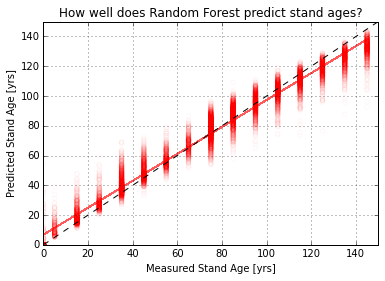

In [17]:
# Data to plot
x = RF_preds.COND_AGE.loc[RF_preds.COND_AGE < age_thresh]
y = RF_preds.RF_AGE.loc[RF_preds.COND_AGE < age_thresh]

plt.figure()
plt.grid(True)
plt.scatter(x, y, alpha = 0.03, facecolors='none', edgecolors='r')
plt.title("How well does Random Forest predict stand ages?")
plt.xlabel("Measured Stand Age [yrs]")
plt.ylabel("Predicted Stand Age [yrs]")
plt.xlim(0,age_thresh)
plt.ylim(0,age_thresh)

# calculate and plot bestfit line with np.polyfit
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, 'r--', alpha = 0.65)

# add a 1:1 line
plt.plot([0, 350], [0, 350], 'k--')

plt.show()

In [18]:
# Predict ages for conditions without ages

# dataframe of conditions without ages, but have all predictor variables
noAges = noNaNs.loc[noNaNs.COND_AGE != noNaNs.COND_AGE]

# RF predictions of ages for conditions without measured ages
RFpred_noAges = pd.Series(randomforest.predict(noAges.drop(labels=droplabels, axis=1))).astype('int')
RFpred_noAges.name = "RF_Age"

# bring predicted ages into the dataframe
RFages_imputed = pd.concat([noAges.reset_index(), RFpred_noAges], axis = 1).set_index("COND_ID")

In [19]:
# Overwrite COND_AGE with RF_Age on PNW FIA DB 2011 dataframe
print(str(len(PNW_FIADB)) + " conditions total")
print(str(PNW_FIADB.COND_AGE.isnull().sum()) + " ages missing before impute")
PNW_FIADB.COND_AGE.loc[PNW_FIADB.COND_AGE != PNW_FIADB.COND_AGE] = RFages_imputed["RF_Age"]
print(str(PNW_FIADB.COND_AGE.isnull().sum()) + " ages missing after impute")
print(str(len(PNW_FIADB)-PNW_FIADB.COND_AGE.isnull().sum()) + " conditions with ages available")

24259 conditions total
1273 ages missing before impute
76 ages missing after impute
24183 conditions with ages available


C:\Users\ddiaz\AppData\Local\Continuum\Anaconda\lib\site-packages\pandas\core\indexing.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [23]:
# write condition unique ID, LAT, LON, slope, aspect, elevation, and stand age to a csv
# based on idb_summary format used in Forest Planner

PNW_FIADB2011_cond_summary = PNW_FIADB[["LAT", "LON", "ELEV", "ASPECT", "SLOPE", "COND_AGE"]].dropna(axis=0, how='any', thresh=None, subset=["COND_AGE", "ELEV", "ASPECT", "SLOPE"], inplace=False)
PNW_FIADB2011_cond_summary[["COND_AGE"]] = PNW_FIADB2011_cond_summary[["COND_AGE"]].astype(int)
PNW_FIADB2011_cond_summary[["ELEV"]] = PNW_FIADB2011_cond_summary[["ELEV"]].astype(int)
PNW_FIADB2011_cond_summary[["SLOPE"]] = PNW_FIADB2011_cond_summary[["SLOPE"]].astype(int)
PNW_FIADB2011_cond_summary[["ASPECT"]] = PNW_FIADB2011_cond_summary[["ASPECT"]].astype(int)
PNW_FIADB2011_cond_summary.to_csv("G:/projects/ForestPlanner_2015/Data/Processed/IDB2pt0_COND_SUMMARY_ages-imputed_2015-11-02.csv", header = True, index = True)